# McDonald's Corporation (MCD) Stock Prices, Dividends and Splits


In [1]:
## import library
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd   
import quandl
import numpy as np
import matplotlib.pyplot as plt  #for plotting
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing,cross_validation
from sklearn.svm import SVR
#from mlxtend.regressor import StackingRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error



/home/pirate/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
## data source 
quandl.ApiConfig.api_key = "zuiQMfguw3rRgLvkCzxk"
df=quandl.get('EOD/MCD')

In [3]:
##data summary
df.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
1970-01-02,43.00,44.25,43.0,44.25,23256.0,0.0,1.0,0.197684,0.203430,0.197684,0.203430,2825604.0
1970-01-05,44.25,45.00,44.0,45.00,18193.0,0.0,1.0,0.203430,0.206878,0.202281,0.206878,2210449.5
1970-01-06,45.00,45.75,45.0,45.25,16059.0,0.0,1.0,0.206878,0.210326,0.206878,0.208028,1951168.5
1970-01-07,45.25,45.75,45.0,45.00,22459.0,0.0,1.0,0.208028,0.210326,0.206878,0.206878,2728768.5
1970-01-08,45.00,45.38,45.0,45.00,18456.0,0.0,1.0,0.206878,0.208625,0.206878,0.206878,2242404.0


In [4]:
## redefining data adding removin feture
### create the specfic ammount of label and feture 
df1=df[['Adj_Open','Adj_High','Adj_Low','Adj_Close','Adj_Volume']]

###redefining the data
### adding some feture to the datasets
df1['volatility']=(df1['Adj_High']-df1['Adj_Close'])/df1['Adj_Close']
df1['PCT_Change']=(df1['Adj_Close']-df1['Adj_Open'])/df1['Adj_Open'] 

In [5]:
## making final dataframe
df1=df1[['Adj_Close','volatility','PCT_Change','Adj_Open','Adj_Volume']]

In [6]:
## setting the target column
forcast_col='Adj_Close'

In [7]:
## deal with the null data
df1.fillna(-999999,inplace=True)

In [8]:
## for predicting one percent of the data
import math
forcast_out = int(math.ceil(.1*(len(df1))))
print forcast_out

1232


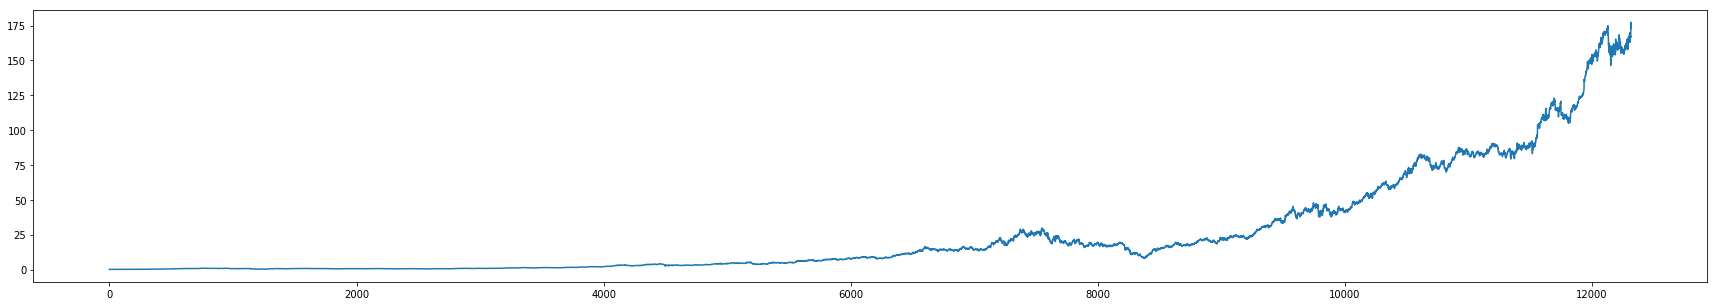

In [9]:
## displaying the previous output
Y=df1[forcast_col]
X=range(len(df1[forcast_col]))
fig_size=[30,5]
plt.rcParams["figure.figsize"] = fig_size
plt.plot(X,Y)

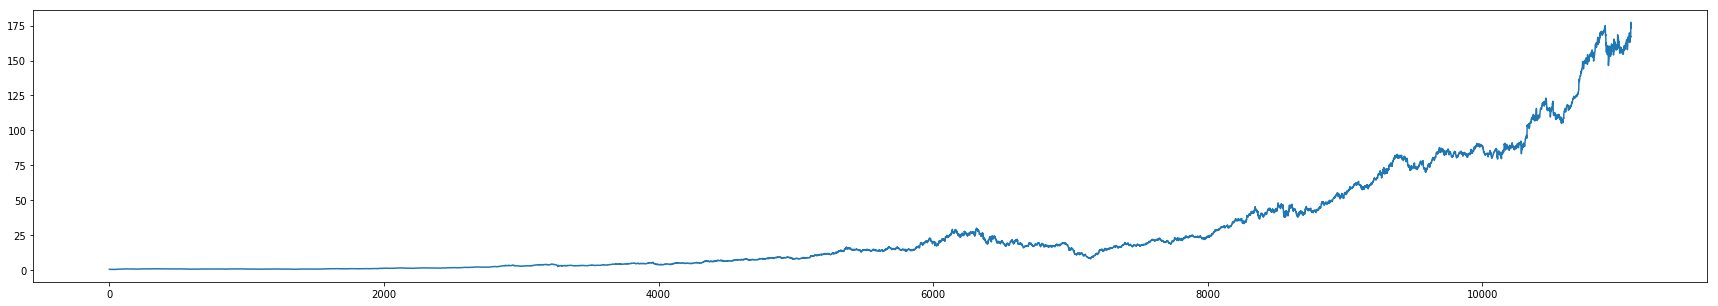

In [10]:
##storing the previous data in  a dataframe
df1['label'] = df[forcast_col].shift(-forcast_out)
y1 = df1['label']
x1=range(len(df1['label']))
fig_size=[30,5]
plt.rcParams["figure.figsize"] = fig_size
plt.plot(x1,y1)

In [11]:
## dropping the first column which is the output
X=np.array(df1.drop(['label'],1))

In [12]:
##scale the data
X=preprocessing.scale(X)
X=X[:-forcast_out]  ##data what is known
X_lately=X[-forcast_out:] ##data we predict
df1.dropna(inplace=True)

In [13]:
Y=np.array(df1['label'])

In [14]:
##split the training and testing data
xtrain,xtest,ytrain,ytest=cross_validation.train_test_split(X,Y,test_size=0.2)

In [15]:
## training separtely the classifier
##first knn
n_neighbors=1
clf1 = KNeighborsRegressor(n_neighbors)  # create a classifire object
clf1.fit(xtrain,ytrain) # train data related with fir() method
accuracy1=clf1.score(xtest,ytest) # test data related with score() method
print "the accuracy is "+str(accuracy1)

the accuracy is 0.917859551894287


In [16]:
## second linear regression
from sklearn.linear_model import LinearRegression
clf2 = LinearRegression()  # create a classifire object
clf2.fit(xtrain,ytrain) # train data related with fir() method
accuracy2=clf2.score(xtest,ytest) # test data related with score() method
print "the accuracy is "+str(accuracy2)


the accuracy is 0.9377353611084109


In [17]:
## third support vector machine
from sklearn import svm
clf3 = svm.SVR()  # create a classifire object
clf3.fit(xtrain,ytrain) # train data related with fir() method
accuracy3=clf3.score(xtest,ytest) # test data related with score() method
print "the accuracy is "+str(accuracy3)

the accuracy is 0.9109966359126223


In [18]:
clf4 = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
clf4.fit(xtrain,ytrain) # train data related with fir() method
accuracy4=clf4.score(xtest,ytest) # test data related with score() method
print "the accuracy is "+str(accuracy4)

the accuracy is 0.927039864127283


# applying the stacking method we developed

In [19]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   


In [20]:
averaged_models = AveragingModels(models = (clf1, clf2, clf3, clf4))

In [21]:
averaged_models.fit(xtrain,ytrain)

AveragingModels(models=(KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform'), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsi..._estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)))

In [22]:
accuracy=averaged_models.score(xtest,ytest)

In [23]:
accuracy

0.9473287888219077

## This is better than the individual one

In [24]:
df2=pd.DataFrame()
df3=pd.DataFrame()
df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()

In [25]:
forcast_set1=clf1.predict(X_lately)
forcast_set2=clf2.predict(X_lately)
forcast_set3=clf3.predict(X_lately)
forcast_set4=clf4.predict(X_lately)
final_forcast_set=averaged_models.predict(X_lately)
df2['forcast']=np.array(forcast_set1)
df3['forcast']=np.array(forcast_set2)
df4['forcast']=np.array(forcast_set3)
df5['forcast']=np.array(forcast_set4)
df6['forcast']=np.array(final_forcast_set)


Text(0,0.5,'Price')

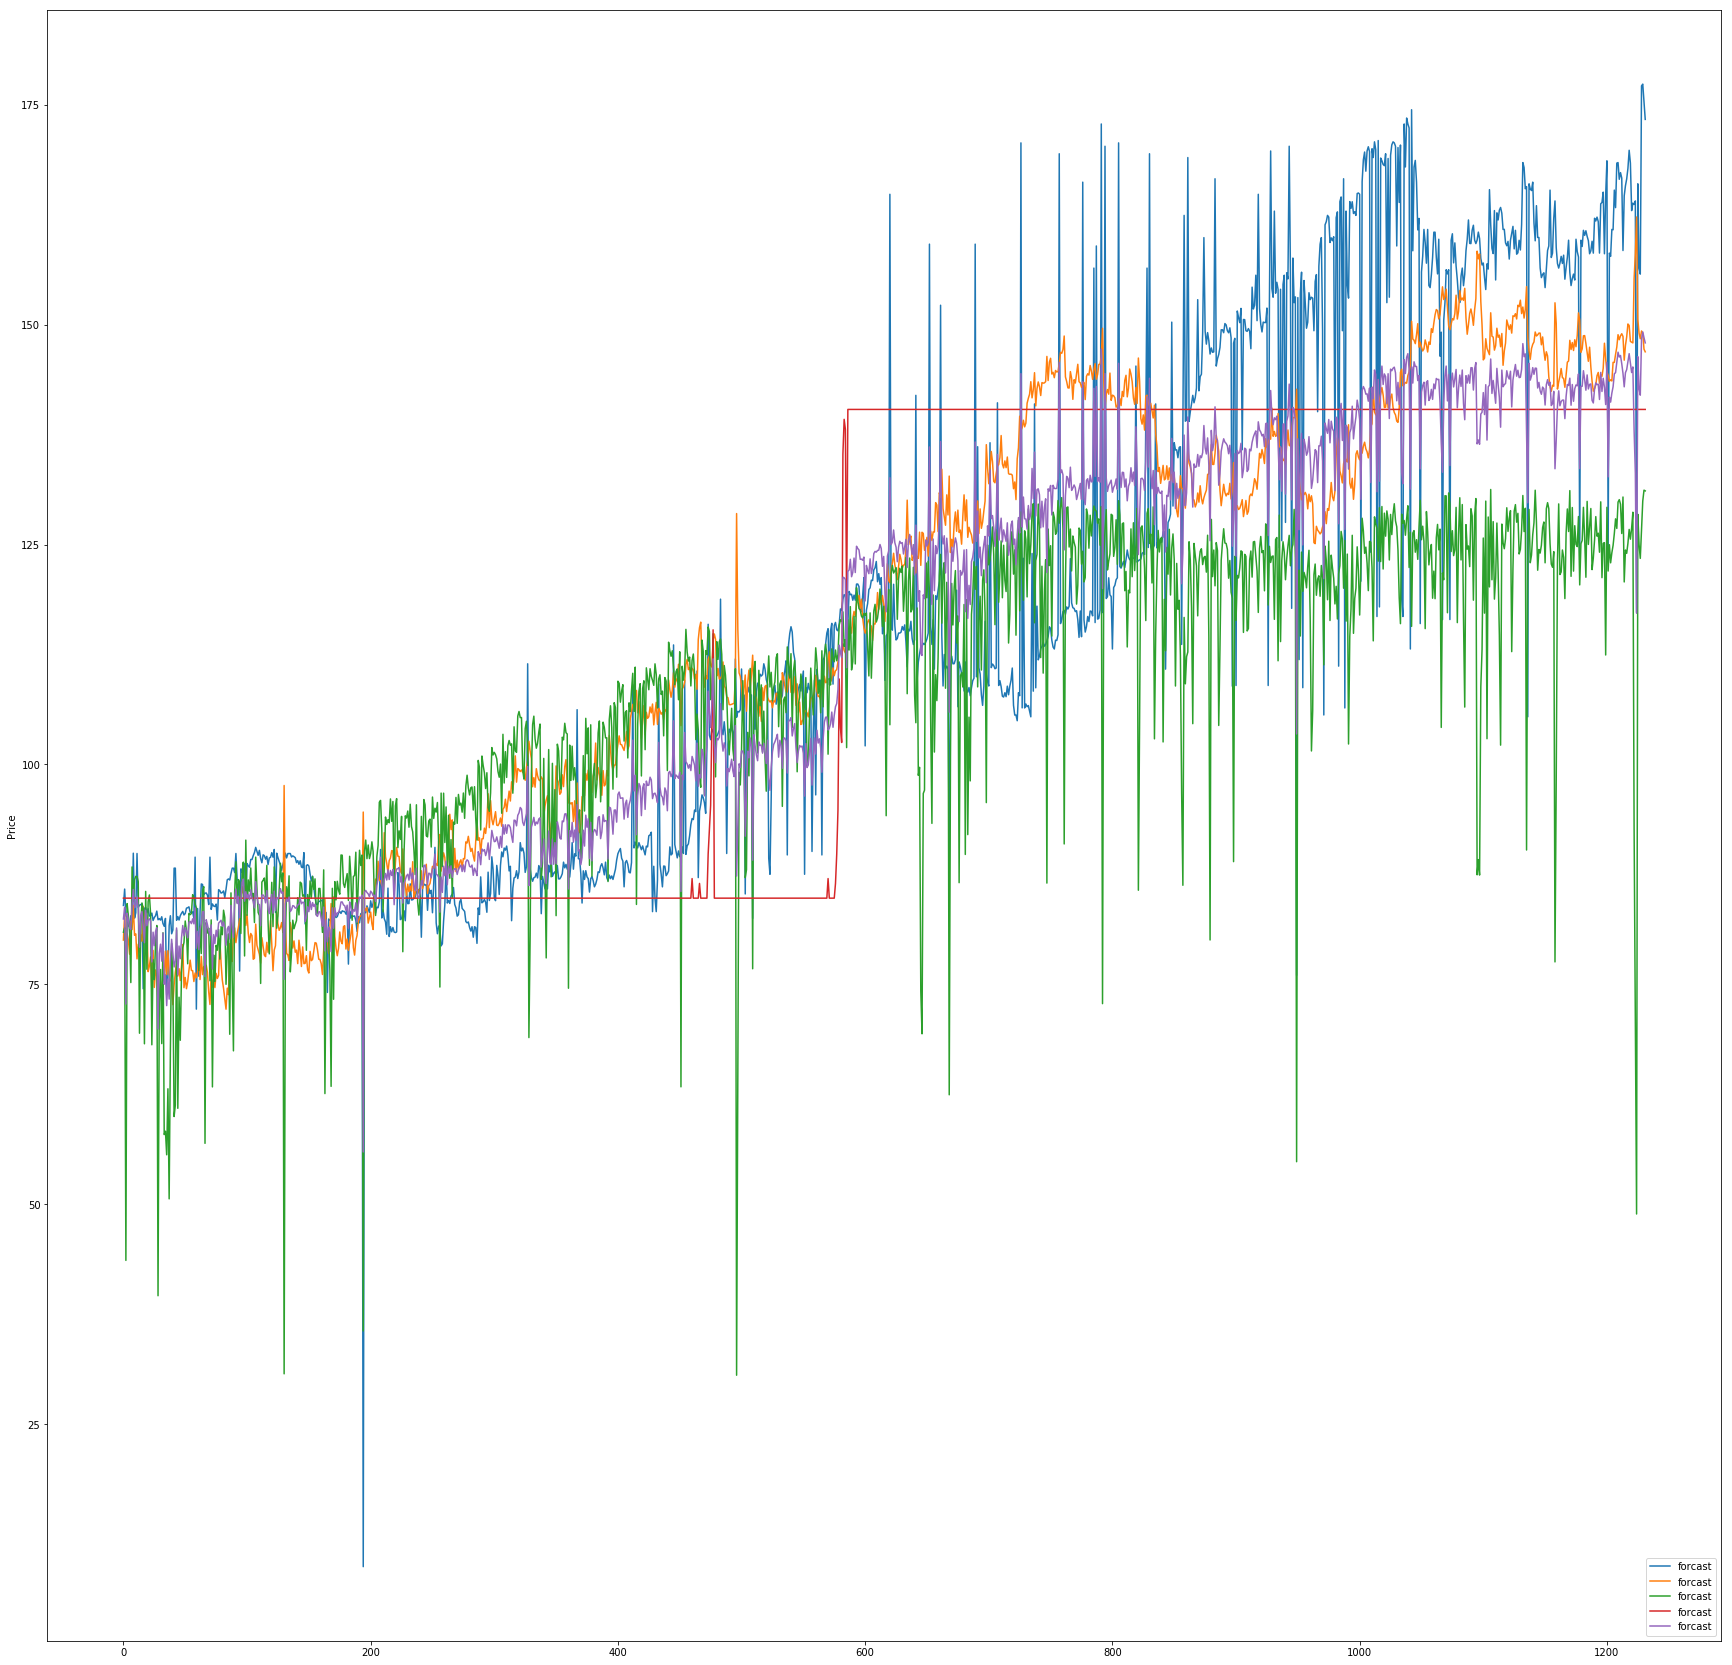

In [26]:
fig_size=[30,30]
plt.rcParams["figure.figsize"] = fig_size
df2['forcast'].plot()
df3['forcast'].plot()
df4['forcast'].plot()
df5['forcast'].plot()
df6['forcast'].plot()
plt.legend(loc=4)

plt.ylabel('Price')

## The Orange one is our improved stacked model output, less noise more accuracy